In [1]:
import os
import gc
import numpy as np
import pandas as pd
import polars as pl
from glob import glob
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import optuna
from sklearn.model_selection import cross_validate
from lightgbm import LGBMRegressor
# import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

# Reading the data

In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')
sub_data = pd.read_csv('/kaggle/input/playground-series-s4e5/sample_submission.csv')

## train data

In [3]:
train_data.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

- no object type
- no missing value

In [10]:
train_data.duplicated().sum()

0

## test data

In [6]:
test_data.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,...,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,...,4,3,2,6,4,6,8,4,5,5


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745305 entries, 0 to 745304
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   id                               745305 non-null  int64
 1   MonsoonIntensity                 745305 non-null  int64
 2   TopographyDrainage               745305 non-null  int64
 3   RiverManagement                  745305 non-null  int64
 4   Deforestation                    745305 non-null  int64
 5   Urbanization                     745305 non-null  int64
 6   ClimateChange                    745305 non-null  int64
 7   DamsQuality                      745305 non-null  int64
 8   Siltation                        745305 non-null  int64
 9   AgriculturalPractices            745305 non-null  int64
 10  Encroachments                    745305 non-null  int64
 11  IneffectiveDisasterPreparedness  745305 non-null  int64
 12  DrainageSystems               

## submission data

In [11]:
sub_data.head()

,id,FloodProbability
0,1117957,0.5
1,1117958,0.5
2,1117959,0.5
3,1117960,0.5
4,1117961,0.5


# make LGBM model

In [12]:
train_df = train_data.drop(['id', 'FloodProbability'], axis=1)
target_df = train_data['FloodProbability']

In [13]:
cols = train_df.columns

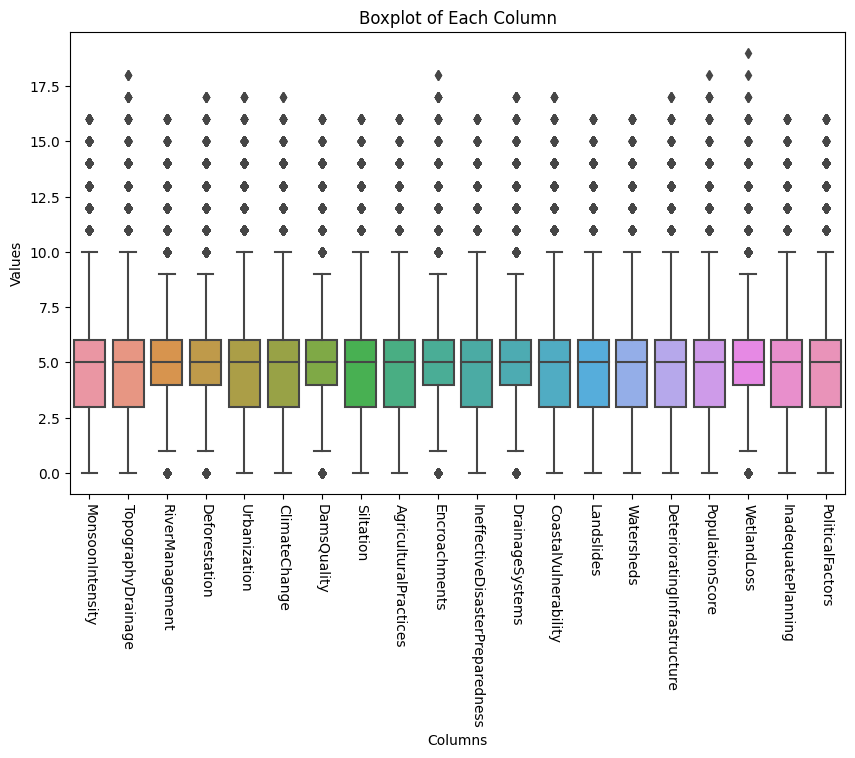

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df)
plt.title('Boxplot of Each Column')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.show()

In [20]:
def replace_outliers_with_boundary(df):
    for column in df.columns:
        mean = df[column].mean()
        std_dev = df[column].std()
        lower_bound = mean - 3 * std_dev
        upper_bound = mean + 3 * std_dev
        
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

# 外れ値を境界値に書き換え
train_df = replace_outliers_with_boundary(train_df)

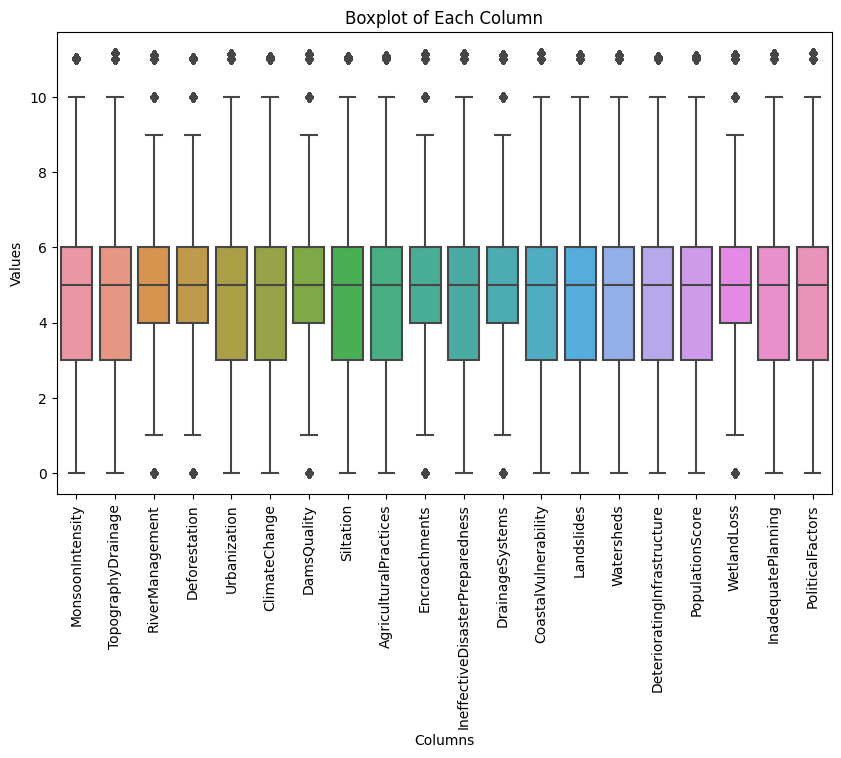

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df)
plt.title('Boxplot of Each Column')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.show()

In [22]:
scaler = MinMaxScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=cols)

In [40]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 5, 15)
    n_estimators = trial.suggest_int('n_estimators', 1000, 30000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 5, 15)
    subsample = trial.suggest_float('subsample', 0, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.5, 1.5)
    
#     print('Training the model with', X.shape[1], 'features')
    
#       LightGBM
    params = {'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'max_depth': max_depth,
              'lambda_l1': reg_alpha,
              'lambda_l2': reg_lambda,
              'colsample_bytree': colsample_bytree, 
              'subsample': subsample,    
              'min_child_samples': min_child_weight,
              'class_weight': 'balanced'}
    
    clf = LGBMRegressor(**params, verbose = -1, verbosity = -1)
    
    cv_results = cross_validate(clf,train_df,target_df, cv=5, scoring='r2')
    
    validation_score = np.mean(cv_results['test_score'])
    
    return validation_score

In [42]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials= 5)

[I 2024-05-21 13:01:14,105] A new study created in memory with name: no-name-ed4839a3-f490-4b14-9122-809f197ca00e
[I 2024-05-21 13:02:14,594] Trial 0 finished with value: 0.8161988577160901 and parameters: {'max_depth': 4, 'n_estimators': 192, 'gamma': 0.37760156054482374, 'reg_alpha': 0.873943098592371, 'reg_lambda': 0.5062081444875907, 'min_child_weight': 13, 'subsample': 0.41600402073495557, 'colsample_bytree': 0.012860109556730226, 'learning_rate': 0.917709689546901}. Best is trial 0 with value: 0.8161988577160901.


In [43]:
df_study = study.trials_dataframe()
df_study = df_study.sort_values(by='value', ascending=False)

df_study.head()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample,state
0,0,0.816199,2024-05-21 13:01:14.107815,2024-05-21 13:02:14.594184,0 days 00:01:00.486369,0.01286,0.377602,0.91771,4,13,192,0.873943,0.506208,0.416004,COMPLETE


In [45]:
best_params_LGBM = study.best_params

print(best_params_LGBM)

{'max_depth': 4, 'n_estimators': 192, 'gamma': 0.37760156054482374, 'reg_alpha': 0.873943098592371, 'reg_lambda': 0.5062081444875907, 'min_child_weight': 13, 'subsample': 0.41600402073495557, 'colsample_bytree': 0.012860109556730226, 'learning_rate': 0.917709689546901}


In [51]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

#     def predict_proba(self, X):
#         y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
#         return np.mean(y_preds, axis=0)

In [68]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fitted_models = []
cv_scores = []


for idx_train, idx_valid in kf.split(train_df):
    X_train, y_train = train_df.iloc[idx_train], target_df.iloc[idx_train]
    X_valid, y_valid = train_df.iloc[idx_valid], target_df.iloc[idx_valid]

    model = lgb.LGBMRegressor(**best_params_LGBM)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(50), lgb.early_stopping(50)]
    )

    fitted_models.append(model)


    y_pred_valid = model.predict(X_valid)
    r2 = r2_score(y_valid, y_pred_valid)
    cv_scores.append(r2)

model = VotingModel(fitted_models)
print("CV AUC scores: ", cv_scores)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 20
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [ ]:
# separate the data
X_train, X_test, y_train, y_test = train_test_split(train_df, target_df, test_size=0.2, random_state=42)

# set hyperparameter
params = {
    'objective': 'regression',
    'metric': 'r2',
    'learning_rate': 0.1,
    'n_estimators': 50000,
    'max_depth': 10,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'num_leaves': 64
}

# instantiation
model = lgb.LGBMRegressor(**params)

# study & pridict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# calc r2 score
r2_score = r2_score(y_test, y_pred)
print('---------------------------')
print("r2 score:", r2_score)

# plot feature importance

model.plot_importance(model)

# submission

In [71]:
test_df = test_data.drop(['id'], axis=1)
y_pred_sub = model.predict(test_df)

# submission df
sub = pd.DataFrame()
sub['id'] = test_data['id']
sub['FloodProbability'] = y_pred_sub

sub.head()

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma


,id,FloodProbability
0,1117957,1.330967
1,1117958,1.330967
2,1117959,1.330967
3,1117960,1.330967
4,1117961,1.330967


In [72]:
sub.to_csv('submission.csv', index=False)